In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initializing parameters
Bi = 10000
n = [50, 50]
k = [1, 1]
l = [1, 1]

omega = np.logspace(-1, 2)
deltax = np.zeros(len(n))
D = np.zeros(len(n))
alpha = np.zeros(len(n), dtype=complex)
lamb = np.zeros(len(n), dtype=complex)

# Defining indices for pore terminations
l1 = n[0] + 1
l2 = l1 + n[1] + 2

# Define variables based on parameters
for i in range(len(n)):
    deltax[i] = l[i] / (n[i] + 1)
    D[i] = k[i] / np.tanh(k[i])

# Initialize Solutions
Z_numerical = np.array([])
Z_analytical = np.array([])
Z_1 = np.array([])
Z_2 = np.array([])

for w in omega:
    ## Numerical Solution
    # Defining step
    step = 1

    # Initializing A array
    A = np.zeros((l2 + 1, l2 + 1), dtype=complex)

    # Initializing b vector
    b = np.zeros((l2 + 1), dtype=complex)
    
    for i in range(len(n)):
        # Creating unique lambda for each pore
        # alpha is for analytical solution and lambda is for numerical solutions
        lamb[i] = 1j * w * deltax[i] ** 2 / D[i]
        alpha[i] = np.sqrt(1j * w / D[i])
        
        for j in range(step, n[i] + step):
            # Creating A array
            A[j, j - 1] = 1
            A[j, j] = -(2 + lamb[i])
            A[j, j + 1] = 1

            # Creating b vector
            b[j] = -lamb[i]

        step = step + n[i] + 2 # updates translation of the points - always increases by n + 2 where n is the # of inner pts
        
    ## Applying boundary conditions
    # Current matching from reservoir to pore network inlet
    A[0, 0] = -(2 * deltax[0] * Bi + 2 + lamb[0])
    A[0, 1] = 2
    b[0] = -lamb[0]

    # No current at pore 2 termination
    A[l2, l2 - 1] = 2
    A[l2, l2] = -(2 + lamb[1])
    b[l2] = -lamb[1]

    # Current balance at the tjunction

    # Current into junction from pore 1
    A[l1, l1 - 2] = 3 * k[0] / 2 / deltax[0]
    A[l1, l1 - 1] = -4 * k[0] / 2 / deltax[0]
    A[l1, l1] = k[0] / 2 / deltax[0]

    # Current from junction into pore 2
    A[l1, l1 + 1] = k[1] / 2 / deltax[1]
    A[l1, l1 + 2] = -4 * k[1] / 2 / deltax[1]
    A[l1, l1 + 3] = 3 * k[1] / 2 / deltax[1]

    b[l1] = 0

    # Electrochemical potential matching across tjunction

    # Pore 1 to Pore 2
    A[l1 + 1, l1] = 1
    A[l1 + 1, l1 + 1] = -1
    b[l1 + 1] = 0

    # X array outputs chemical potentials at all deltax locations in each pore
    # The first n entries are pore 1 and the second n entries are pore 2
    X = np.linalg.solve(A, b)
    
    
    ## Analytical Solution
    # Plugging in boundary Conditions
    C = np.array([
        [Bi / alpha[0], 0, -1, 0],
        [0, np.tanh(-alpha[1] * l[1]), 0, -1],
        [k[0] * alpha[0] * np.sinh(alpha[0] * l[0]), 0, k[0] * alpha[0] * np.cosh(alpha[0] * l[0]), -k[1] * alpha[1]],
        [np.cosh(alpha[0] * l[0]), -1, np.sinh(alpha[0] * l[0]), 0]
    ])
    d = np.array([-Bi/alpha[0], 0, 0, 0])
    # Y array outputs A1, A2, B1, B2 for the general analytical solution
    Y = np.linalg.solve(C, d)
    
    
    ## Textbook Solutions
    # Defining variables for one "equivalent" pore
    l_tot = np.sum(l)
    D_ave = np.sum(np.array(D) * np.array(l)) / np.sum(np.array(l))
    
    # Single pore solutions
    # z_long = (np.tanh(l_tot * (1j * w / D_ave) ** 0.5)) ** (-1) / (1j * w / D_ave) ** 0.5
    z1_trans = (np.tanh(l[0] * (1j * w / D[0]) ** 0.5)) / (1j * w / D[0]) ** 0.5
    z2_trans = (np.tanh(l[1] * (1j * w / D[1]) ** 0.5)) / (1j * w / D[1]) ** 0.5
    z1_ref = (np.tanh(l[0] * (1j * w / D[0]) ** 0.5)) ** (-1) / (1j * w / D[0]) ** 0.5
    z2_ref = (np.tanh(l[1] * (1j * w / D[1]) ** 0.5)) ** (-1) / (1j * w / D[1]) ** 0.5
    
    # Creating solutions
    Z_numerical = np.append(Z_numerical, 1 / X[0] / Bi)
    Z_analytical = np.append(Z_analytical, 1 / (Bi * (1 + Y[0])))
    Z_1 = np.append(Z_1, 1 / Bi + z1_ref * z2_ref / (z1_ref + z2_ref) + z1_trans * z2_trans / (z1_trans + z2_trans))
    Z_2 = np.append(Z_2, 1 / Bi + z1_trans + z2_ref)

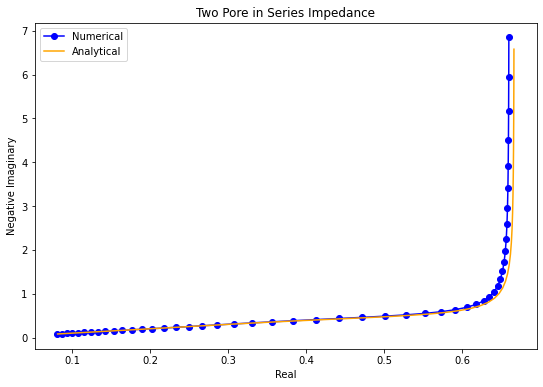

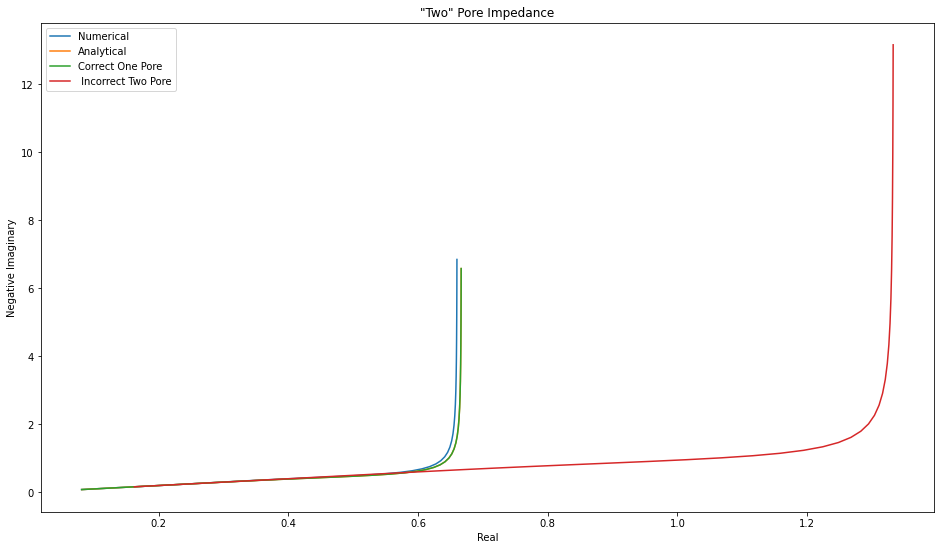

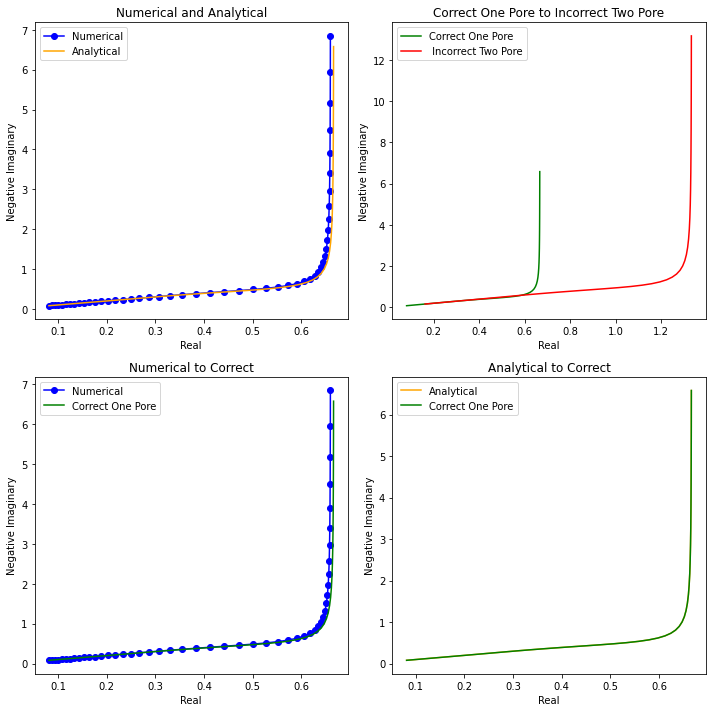

In [9]:
# Initialize a list of labels for the legend
labels = ['Numerical', 'Analytical', 'Correct One Pore', ' Incorrect Two Pore']

# Initialize a list of data arrays
data_arrays = [Z_numerical, Z_analytical, Z_1, Z_2]

plt.figure(figsize=(9, 6))
plt.plot(data_arrays[0].real, -data_arrays[0].imag, label=labels[0], color='blue', marker='o')
plt.plot(data_arrays[1].real, -data_arrays[1].imag, label=labels[1], color='orange')
plt.title('Two Pore in Series Impedance')
plt.xlabel('Real')
plt.ylabel('Negative Imaginary')
plt.legend()

# Set figure size
plt.figure(figsize=(16, 9))

# Plot real and negative imaginary parts of impedance
for i in range(len(data_arrays)):
    plt.plot(data_arrays[i].real, -data_arrays[i].imag, label=labels[i])

# Figure formatting
plt.title('"Two" Pore Impedance')
plt.xlabel('Real')
plt.ylabel('Negative Imaginary')
plt.legend()
plt.show()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Top-left subplot:
axes[0, 0].plot(data_arrays[0].real, -data_arrays[0].imag, label=labels[0], color='blue', marker='o')
axes[0, 0].plot(data_arrays[1].real, -data_arrays[1].imag, label=labels[1], color='orange')
axes[0, 0].set_title('Numerical and Analytical')
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Negative Imaginary')
axes[0, 0].legend()

# Top-right subplot:
axes[0, 1].plot(data_arrays[2].real, -data_arrays[2].imag, label=labels[2], color='green')
axes[0, 1].plot(data_arrays[3].real, -data_arrays[3].imag, label=labels[3], color='red')
axes[0, 1].set_title('Correct One Pore to Incorrect Two Pore')
axes[0, 1].set_xlabel('Real')
axes[0, 1].set_ylabel('Negative Imaginary')
axes[0, 1].legend()

# Bottom-left subplot:
axes[1, 0].plot(data_arrays[0].real, -data_arrays[0].imag, label=labels[0], color='blue', marker='o')
axes[1, 0].plot(data_arrays[2].real, -data_arrays[2].imag, label=labels[2], color='green')
axes[1, 0].set_title('Numerical to Correct')
axes[1, 0].set_xlabel('Real')
axes[1, 0].set_ylabel('Negative Imaginary')
axes[1, 0].legend()

# Bottom-right subplot:
axes[1, 1].plot(data_arrays[1].real, -data_arrays[1].imag, label=labels[1], color='orange')
axes[1, 1].plot(data_arrays[2].real, -data_arrays[2].imag, label=labels[2], color='green')
axes[1, 1].set_title('Analytical to Correct')
axes[1, 1].set_xlabel('Real')
axes[1, 1].set_ylabel('Negative Imaginary')
axes[1, 1].legend()

# Add spacing between subplots to prevent overlapping labels
plt.tight_layout()

# Display the subplots
plt.show()